In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import smogn
import seaborn as sns

In [3]:
seed = 8

In [12]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_squared_log_error
def evaluate(y_pred, y_test):
    """ Prints out the evaluation metrics of the experiment
        parameters:
            y_pred
                DataFrame or array-like, the predictions
            y_test
                DataFrame or array-like, the actual y-values
                
            these two parameters must have the same dimensions
    """
    print("r^2: ", r2_score(y_test, y_pred))
    print("mse: ", mean_squared_error(y_test, y_pred))
    print("variance_score: ", explained_variance_score(y_test, y_pred))
    print("mse-log: ", mean_squared_log_error(y_test, y_pred))

In [13]:
def run(model, model_name, x_train, x_val):
    """ Fits the model and prints out results from calling evaluate on the training and validation set
        parameters:
            model
                the unfitted model, from sklearn (has to have a fit and predict method)
            model_name
                String, the name of the model
            x_train
                DataFrame, the training set
            x_val
                DataFrame, the validation set
                
        returns:
            nothing
        
    """
    model = model.fit(x_train, y_train)
    y_pred = np.clip(model.predict(x_train), 0, 1000) # since negative results are meaningless
    
    print("[{0}] These are the results for the training set.".format(model_name))
    
    evaluate(y_pred, y_train)
    print("--------------------------------------")
    
    print("[{0}] These are the results for the validation set.".format(model_name))
    y_pred = np.clip(model.predict(x_val), 0, 1000) # since negative results are meaningless
    
    evaluate(y_pred, y_val)
    
    print("_____________________________________________")

In [247]:
df = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")
df = df[df['poss'] >= 500]
injury = pd.read_excel("../spring21_data/season_ending_injury.xlsx")
injury_fa = df.merge(right=injury, how='inner', left_on=['clean_season', 'Player'], right_on=['clean_season', 'Player']).rename(columns={'Unnamed: 0': 'index'})
df = df[~df['Unnamed: 0'].isin(injury_fa['index'])]
df = df.select_dtypes(exclude=['object'])
df.drop(columns=["Unnamed: 0", "Minutes", "salary", "clean_season", "age", "end season_y", "season_end"], inplace=True)

X = df.drop(columns=["cap_space_usage"])
y = df["cap_space_usage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)
both = pd.concat([X_train, y_train], axis=1).reset_index().drop(columns=["index"])
smote_data_high = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'high',
                           rel_thres = 0.85,
                           k = 11,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'balance')
smote_data_mid = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'both',
                           rel_thres = 0.25,
                           k = 11,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'extreme')
smote_data_low = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'both',
                           rel_thres = 0.001,
                           k = 11,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'extreme')
smote_data = pd.concat([smote_data_high, smote_data_mid, smote_data_low], ignore_index=True).drop_duplicates()
sm = smote_data.sample(frac=1) ## make sure to shuffle the rows otherwise the cross validation will be scuffed
y = sm[['cap_space_usage']]
X = sm.drop(columns=['cap_space_usage'])

r_index: 100%|##########| 27/27 [00:00<00:00, 299.72it/s]


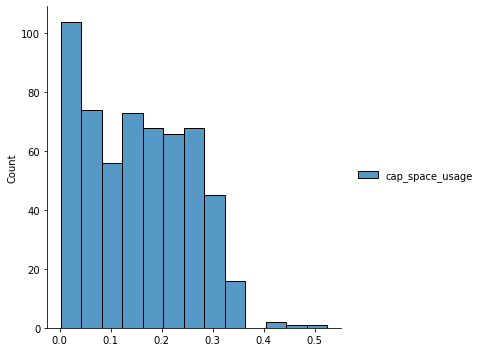

In [248]:
sns.displot(y)

In [7]:
X = pd.read_excel('X.xlsx')
y = pd.read_excel('y.xlsx')
X_test = pd.read_excel('X_test.xlsx')
y_test = pd.read_excel('y_test.xlsx')

In [8]:
X.set_index('Unnamed: 0', inplace=True)
X_test.set_index('Unnamed: 0', inplace=True)
y.set_index('Unnamed: 0', inplace=True)
y_test.set_index('Unnamed: 0', inplace=True)

In [9]:
from sklearn.feature_selection import SelectKBest, f_regression
select = SelectKBest(f_regression, k=40)

best_features = select.fit_transform(X, y)
feature_scores = pd.concat([pd.Series(X.columns), pd.Series(select.scores_)], axis=1)
feature_scores.columns = ["features", "score"]
features = list(feature_scores.sort_values(by=["score"], ascending=False).head(25)['features'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=seed)

X_train = X_train[features]
X_test = X_test[features]
X_val = X_val[features]

/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [20]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in tree
n_estimators = range(25, 650, 25)

# Maximum number of levels in tree
max_depth = range(3, 10)

min_child_weight = range(1,7)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_child_weight': min_child_weight,
               'gamma':[i/10.0 for i in range(0,20)],
               'colsample_bytree': [i/100.0 for i in range(60, 90, 5)],
               'learning_rate': [i/100.0 for i in range(5, 20, 5)],
               'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

In [21]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgb = XGBRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 300, cv = 7, verbose=3, random_state=seed, n_jobs = -1)
# Fit the random search model
xgb_random.fit(X_train, y_train)

Fitting 7 folds for each of 300 candidates, totalling 2100 fits


RandomizedSearchCV(cv=7,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                   n_iter=300, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.65, 0.7,
                                                             0.75, 0.8,

In [22]:
xgb_random.best_params_

{'reg_alpha': 1e-05,
 'n_estimators': 375,
 'min_child_weight': 5,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'colsample_bytree': 0.65}

In [78]:
reg_alpha= 1e-05,
 n_estimators= 375,
 min_child_weight= 5,
 max_depth= 8,
 learning_rate= 0.11,
 gamma= 0.0,
 colsample_bytree= 0.65

{'reg_alpha': 1e-05}

In [65]:
xgb = XGBRegressor(reg_alpha= 1e-05,
 n_estimators= 475,
 min_child_weight= 5,
 max_depth= 8,
 learning_rate= 0.11,
 gamma= 0.002,
 colsample_bytree= 0.86)

run(xgb, "XGB", X_train[features], X_val[features])

[XGB] These are the results for the training set.
r^2:  0.9823970559702921
mse:  0.00018298462167115826
variance_score:  0.982397055970383
mse-log:  0.00014046744571752427
--------------------------------------
[XGB] These are the results for the validation set.
r^2:  0.8442298687665639
mse:  0.001596290055727733
variance_score:  0.8448437238501463
mse-log:  0.0011895435955914717
_____________________________________________
/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [66]:
evaluate(xgb.predict(X_test[features]), y_test)

r^2:  0.8852489603343832
mse:  0.0009075858181907569
variance_score:  0.8852496461829983
mse-log:  0.0007308972112913627
/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [67]:
data = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")

In [68]:
test_index = X_test.index
test_data = data.iloc[test_index][['clean_season','Player','MPG', 'attempted_field_goals', 'minutes_played', 'WS', 'Wins Added', 'poss','cap_space_usage']]
results = pd.concat([test_data, pd.DataFrame(index=test_index, data=xgb.predict(X_test[features]))], axis=1)

/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [69]:
results

,clean_season,Player,MPG,attempted_field_goals,minutes_played,WS,Wins Added,poss,cap_space_usage,0
377,2019,Dragan Bender,18.0,4.282609,17.956522,0.5,0.797767,1778,0.015383,0.035452
105,2016,Wayne Ellington,21.3,7.381579,21.250000,0.8,-1.193968,3266,0.063733,0.026912
60,2016,Dewayne Dedmon,12.2,3.051724,12.155172,2.4,1.009431,1434,0.030783,0.034494
0,2016,Kevin Durant,35.8,19.180556,35.805556,14.5,12.406201,6806,0.281913,0.314710
285,2019,Kawhi Leonard,34.0,18.816667,34.000000,9.5,8.845318,6150,0.300000,0.305128
283,2018,Avery Bradley,31.2,14.250000,31.700000,-0.2,0.433693,2918,0.117798,0.130639
179,2017,Michael Beasley,16.7,7.250000,16.696429,1.8,0.622438,1991,0.014848,0.025044
126,2017,Andre Iguodala,26.3,5.460526,26.289474,6.9,5.790783,5120,0.149504,0.126146
327,2019,Tyus Jones,22.9,6.558824,22.941176,3.0,3.210259,3329,0.077039,0.059790
86,2016,Terrence Jones,20.9,7.340000,20.880000,1.5,-0.660942,2167,0.011163,0.033124
